<a href="https://colab.research.google.com/github/cdiegor/Simulacao/blob/main/Pr%C3%A1tica_2_Gera%C3%A7%C3%A3o_de_vari%C3%A1veis_discretas_e_cont%C3%ADnuas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Geração de Variáveis Aleatórias **Discretas** e **Contínuas**



## Sumário
1. Ambiente & utilitários (RNG, validação e benchmarks)  
2. Parte A — **Discretas**: categórica (CDF inversa/alias), geométrica, negativa binomial, Poisson, binomial, hipergeométrica, uniforme discreta, Fenwick  
3. Parte B — **Contínuas**: uniforme, exponencial, Cauchy, Normal (Polar), Gama (Marsaglia–Tsang), Beta, Qui‑quadrado, t‑Student, Lognormal, A–R genérica, misturas, normal truncada  
4. Visualização com `matplotlib` (sem estilos/cores específicas)  
5. Demonstrações rápidas (discretas e contínuas)  
6. **Exercícios com testes** (para entrega/autoavaliação)

## 1) Ambiente & Utilitários

In [ ]:
# =========================
# 1) Ambiente & Utilitários
# =========================
import numpy as np
import time, math
import matplotlib.pyplot as plt

def make_rng(seed=None):
    return np.random.Generator(np.random.PCG64(seed))

# --- Discreto: qui-quadrado ---
def chisq_discrete(samples, support, pmf):
    samples = np.asarray(samples)
    support = np.asarray(support)
    pmf = np.asarray(pmf, dtype=float)
    n = samples.size
    key_to_idx = {v:i for i, v in enumerate(support)}
    counts = np.zeros_like(pmf, dtype=int)
    for x in samples:
        i = key_to_idx.get(x)
        if i is not None:
            counts[i] += 1
    expected = n * pmf
    obs, expd = counts.astype(float), expected.astype(float)
    if np.any(expd < 5):
        stat = np.sum((obs - expd)**2 / np.maximum(expd, 1e-12))
        df = max(len(pmf) - 1, 1)
        p = np.nan   # rebin recomendado para p adequado
        return stat, df, p
    stat = np.sum((obs - expd)**2 / expd)
    df = len(pmf) - 1
    try:
        from scipy.stats import chi2
        p = chi2.sf(stat, df)
    except Exception:
        z = (stat - df) / math.sqrt(2 * df)
        from math import erf
        p = 0.5 * (1 - erf(z / math.sqrt(2)))
    return stat, df, p

# --- Momentos ---
def check_moments(samples, mean_true, var_true):
    x = np.asarray(samples)
    mean_emp = x.mean()
    var_emp = x.var(ddof=1)
    return mean_emp, var_emp, mean_emp - mean_true, var_emp - var_true

# --- KS para contínuas ---
def ks_continuous(samples, cdf):
    x = np.sort(np.asarray(samples, dtype=float))
    n = x.size
    u = np.array([cdf(xi) for xi in x])
    D_plus  = np.max(np.arange(1, n+1)/n - u)
    D_minus = np.max(u - np.arange(0, n)/n)
    D = max(D_plus, D_minus)
    try:
        from scipy.stats import kstest
        stat, p = kstest(x, cdf)
        return stat, p
    except Exception:
        t = (math.sqrt(n) + 0.12 + 0.11/math.sqrt(n)) * D
        s = 0.0
        for k in range(1, 100):
            s += (-1)**(k-1) * math.exp(-2*(k**2)*(t**2))
        p = max(min(2*s, 1.0), 0.0)
        return D, p

# --- Q-Q Plot ---
def qqplot(samples, q_theory, title="Q–Q Plot"):
    x = np.sort(np.asarray(samples, dtype=float))
    n = x.size
    probs = (np.arange(1, n+1) - 0.5) / n
    q = np.array([q_theory(p) for p in probs])
    plt.figure()
    plt.scatter(q, x, s=4, alpha=0.6)
    mn = min(q.min(), x.min()); mx = max(q.max(), x.max())
    plt.plot([mn, mx], [mn, mx])
    plt.xlabel("Quantis teóricos"); plt.ylabel("Quantis empíricos")
    plt.title(title); plt.show()

# --- Timer ---
def time_draw(fn, *args, repeat=3, **kwargs):
    best = float('inf')
    out = None
    for _ in range(repeat):
        t0 = time.perf_counter()
        out = fn(*args, **kwargs)
        dt = time.perf_counter() - t0
        best = min(best, dt)
    return out, best

## 2) Parte A — Discretas

### 2.1 Categórica: CDF inversa e Alias

In [ ]:
def categorical_inverse(p, size, rng=None):
    rng = make_rng() if rng is None else rng
    p = np.asarray(p, dtype=float); p = p / p.sum()
    cdf = np.cumsum(p)
    u = rng.random(size)
    return np.searchsorted(cdf, u, side='left')

class AliasTable:
    def __init__(self, p):
        p = np.asarray(p, dtype=float)
        if p.sum() <= 0: raise ValueError("As probabilidades devem somar > 0")
        p = p / p.sum(); K = len(p)
        self.prob = np.zeros(K); self.alias = np.zeros(K, dtype=int)
        q = p * K
        small = [i for i, x in enumerate(q) if x < 1.0]
        large = [i for i, x in enumerate(q) if x >= 1.0]
        while small and large:
            i = small.pop(); j = large.pop()
            self.prob[i] = q[i]; self.alias[i] = j
            q[j] = q[j] - (1.0 - q[i])
            if q[j] < 1.0: small.append(j)
            else: large.append(j)
        for j in large + small:
            self.prob[j] = 1.0; self.alias[j] = j
    def sample(self, size, rng=None):
        rng = make_rng() if rng is None else rng
        K = len(self.prob)
        i = (rng.random(size) * K).astype(int)
        u = rng.random(size)
        take = u < self.prob[i]
        return np.where(take, i, self.alias[i])

### 2.2 Outras discretas (Geom., NegBin, Poisson, Binomial, Hipergeom., Uniforme Discreta, Fenwick)

In [ ]:
def geometric_trials(p, size, rng=None):
    rng = make_rng() if rng is None else rng
    u = rng.random(size)
    return 1 + np.floor(np.log1p(-u) / np.log1p(-p)).astype(int)

def geometric_failures(p, size, rng=None):
    rng = make_rng() if rng is None else rng
    u = rng.random(size)
    return np.floor(np.log1p(-u) / np.log1p(-p)).astype(int)

def poisson_knuth(lam, size, rng=None):
    rng = make_rng() if rng is None else rng
    lam = float(lam); L = np.exp(-lam)
    out = np.empty(size, dtype=int)
    for i in range(size):
        k = 0; t = 1.0
        while t > L:
            k += 1; t *= rng.random()
        out[i] = k - 1
    return out

def poisson_any(lam, size, rng=None):
    rng = make_rng() if rng is None else rng
    lam = float(lam)
    if lam <= 30: return poisson_knuth(lam, size, rng)
    return rng.poisson(lam, size)

from math import sqrt
def binomial_inv(n, p, size, rng=None):
    rng = make_rng() if rng is None else rng
    n = int(n); p = float(p); q = 1.0 - p
    out = np.empty(size, dtype=int)
    for i in range(size):
        u = rng.random(); k = 0; w = q**n; c = w
        while u > c and k < n:
            k += 1; w *= (n - (k - 1)) / k * (p / q); c += w
        out[i] = k
    return out

def binomial_normal_approx(n, p, size, rng=None):
    rng = make_rng() if rng is None else rng
    mu = n * p; sigma = sqrt(n * p * (1 - p))
    x = rng.normal(mu, sigma, size)
    return np.clip(np.round(x), 0, n).astype(int)

def binomial_poisson_approx(n, p, size, rng=None):
    rng = make_rng() if rng is None else rng
    lam = n * p; return rng.poisson(lam, size)

def binomial_any(n, p, size, rng=None):
    n = int(n); p = float(p); rng = make_rng() if rng is None else rng
    if n <= 20000 and min(n*p, n*(1-p)) <= 1500:
        return binomial_inv(n, p, size, rng)
    return rng.binomial(n, p, size)

def hypergeom_inv(N, K, n, size, rng=None):
    rng = make_rng() if rng is None else rng
    N = int(N); K = int(K); n = int(n)
    kmin = max(0, n - (N - K)); kmax = min(n, K)
    out = np.empty(size, dtype=int)
    for i in range(size):
        u = rng.random(); k = kmin; w = 1.0; c = w
        while u > c and k < kmax:
            r = ((K - k) * (n - k)) / ((k + 1) * (N - K - n + k + 1))
            w *= r; c += w; k += 1
        out[i] = k
    return out

def discrete_uniform(a, b, size, rng=None):
    rng = make_rng() if rng is None else rng
    a = int(a); b = int(b); R = b - a + 1
    out = np.empty(size, dtype=int)
    for i in range(size):
        while True:
            z = rng.integers(0, 1 << 64, dtype=np.uint64)
            t = ((1 << 64) // R) * R
            if z < t:
                out[i] = a + int(z % R); break
    return out

## 3) Parte B — Contínuas

### 3.1 Básicas por inversa

In [ ]:
def uniform(a=0.0, b=1.0, size=1, rng=None):
    rng = make_rng() if rng is None else rng
    u = rng.random(size); return a + (b - a) * u

def expon(lam=1.0, size=1, rng=None):
    rng = make_rng() if rng is None else rng
    u = rng.random(size); return -np.log1p(-u) / lam

def cauchy(size=1, rng=None):
    rng = make_rng() if rng is None else rng
    u = rng.random(size); return np.tan(np.pi*(u - 0.5))

### 3.2 Normal (Box–Muller e Polar)

In [ ]:
def normal_polar(size=1, rng=None):
    rng = make_rng() if rng is None else rng
    out = np.empty(size); i = 0
    while i < size:
        u = rng.random(2) * 2 - 1; s = u[0]*u[0] + u[1]*u[1]
        if s == 0 or s >= 1: continue
        factor = np.sqrt(-2.0 * np.log(s) / s)
        out[i] = u[0] * factor; i += 1
        if i < size: out[i] = u[1] * factor; i += 1
    return out

def normal(mu=0.0, sigma=1.0, size=1, rng=None, method="polar"):
    z = normal_polar(size, rng)
    return mu + sigma * z

### 3.3 Família Gama/Beta/Qui²/t/Lognormal

In [ ]:

def gamma(k, theta=1.0, size=1, rng=None):
    g = np.array([sum(expon(1/theta, int(k), rng)) for _ in range(size)])
    return g

def beta_ab(a, b, size=1, rng=None):
    rng = make_rng() if rng is None else rng
    x = gamma(a, 1.0, size, rng); y = gamma(b, 1.0, size, rng)
    return x / (x + y)

def chisq(df, size=1, rng=None):
    return gamma(df/2.0, 2.0, size, rng)

def t_student(df, size=1, rng=None):
    rng = make_rng() if rng is None else rng
    z = normal_polar(size, rng); v = chisq(df, size, rng)
    return z / np.sqrt(v/df)

def lognormal(mu=0.0, sigma=1.0, size=1, rng=None):
    z = normal(0.0, 1.0, size, rng, method="polar")
    return np.exp(mu + sigma*z)

### 3.4 A–R genérica, misturas e normal truncada

In [ ]:
def accept_reject(sample_g, g_pdf, M, f_pdf, size=1, rng=None):
    rng = make_rng() if rng is None else rng
    out = np.empty(size); i = 0
    while i < size:
        x = sample_g(1, rng)[0]; u = rng.random()
        if u <= f_pdf(x) / (M * g_pdf(x)):
            out[i] = x; i += 1
    return out

def sample_cauchy(n, rng=None): return cauchy(size=n, rng=rng)
def pdf_cauchy(x): return 1.0/(np.pi*(1.0 + x*x))
def pdf_norm01(x): return (1/np.sqrt(2*np.pi)) * np.exp(-0.5*x*x)

def mixture(sample_funcs, weights, size=1, rng=None):
    rng = make_rng() if rng is None else rng
    w = np.asarray(weights, dtype=float); w = w / w.sum()
    K = len(w); comps = rng.choice(K, size=size, p=w)
    out = np.empty(size)
    for i, c in enumerate(comps):
        out[i] = sample_funcs[c](1, rng)[0]
    return out

def trunc_normal(a, b, size=1, rng=None, method="polar"):
    rng = make_rng() if rng is None else rng
    out = np.empty(size); i = 0
    while i < size:
        x = normal(0,1,1,rng,method=method)[0]
        if a <= x <= b:
            out[i] = x; i += 1
    return out

## 4) Visualização com matplotlib (um gráfico por figura, sem estilos/cores específicas)

In [ ]:
def plot_categorical_empirical_vs_theoretical(samples, p):
    p = np.asarray(p, dtype=float); p = p / p.sum()
    K = len(p); counts = np.bincount(samples, minlength=K)
    emp = counts / counts.sum(); idx = np.arange(K)
    plt.figure()
    plt.bar(idx - 0.2, emp, width=0.4, label="Empírico")
    plt.bar(idx + 0.2, p, width=0.4, label="Teórico")
    plt.xlabel("Categoria"); plt.ylabel("Probabilidade")
    plt.title("Categórica: Empírico vs Teórico"); plt.legend(); plt.show()

def hist_with_pdf(samples, pdf, xmin=None, xmax=None, bins=60, title="Hist vs PDF"):
    x = np.asarray(samples, dtype=float)
    if xmin is None: xmin = np.percentile(x, 0.5)
    if xmax is None: xmax = np.percentile(x, 99.5)
    xs = np.linspace(xmin, xmax, 400)
    plt.figure()
    plt.hist(x, bins=bins, density=True, alpha=0.6)
    plt.plot(xs, [pdf(t) for t in xs])
    plt.xlabel("x"); plt.ylabel("densidade"); plt.title(title); plt.show()

## 5) Demonstrações rápidas

Categórica — Inversa: 0.0048s | Alias: 0.0046s
Qui-quadrado (alias): stat=3.88, gl=4, p=0.4227986827545366


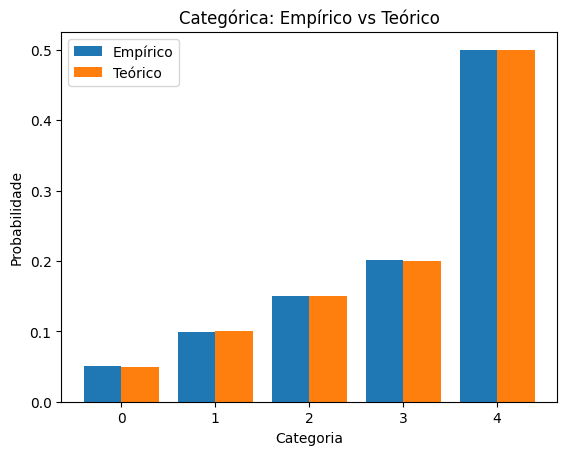

In [ ]:
rng = make_rng(2025)

# Discretas — categórica: inversa vs alias
p = np.array([0.05, 0.10, 0.15, 0.20, 0.50]); alias = AliasTable(p)
x_inv, t_inv = time_draw(categorical_inverse, p, 200_000, rng=rng)
x_alias, t_alias = time_draw(alias.sample, 200_000, rng=rng)
print(f"Categórica — Inversa: {t_inv:.4f}s | Alias: {t_alias:.4f}s")
stat, df, pval = chisq_discrete(x_alias, np.arange(len(p)), p)
print(f"Qui-quadrado (alias): stat={stat:.2f}, gl={df}, p={pval}")
plot_categorical_empirical_vs_theoretical(x_alias, p)

In [ ]:
# Discretas — Poisson e Binomial
for lam in [1, 5, 20]:
    x, t = time_draw(poisson_any, lam, 200_000, rng=rng)
    mean_emp, var_emp, dmu, dvar = check_moments(x, lam, lam)
    print(f"Poisson({lam}): t={t:.4f}s | média={mean_emp:.3f} (Δ{dmu:.3f}) | var={var_emp:.3f} (Δ{dvar:.3f})")

n, pbin = 2000, 0.3
x, t = time_draw(binomial_any, n, pbin, 200_000, rng=rng)
mu = n * pbin; var = n * pbin * (1 - pbin)
mean_emp, var_emp, dmu, dvar = check_moments(x, mu, var)
print(f"Bin({n},{pbin}): t={t:.4f}s | média={mean_emp:.2f} (Δ{dmu:.2f}) | var={var_emp:.2f} (Δ{dvar:.2f})")

Poisson(1): t=0.3377s | média=1.003 (Δ0.003) | var=1.008 (Δ0.008)
Poisson(5): t=0.9002s | média=4.997 (Δ-0.003) | var=4.980 (Δ-0.020)
Poisson(20): t=2.9408s | média=19.989 (Δ-0.011) | var=19.965 (Δ-0.035)
Bin(2000,0.3): t=22.2500s | média=600.04 (Δ0.04) | var=419.42 (Δ-0.58)


Normal Polar: 1.5054s | KS stat=0.0018 p=0.2790545034906343


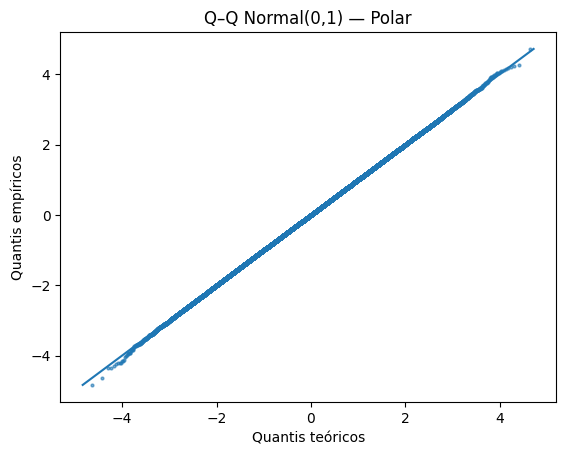

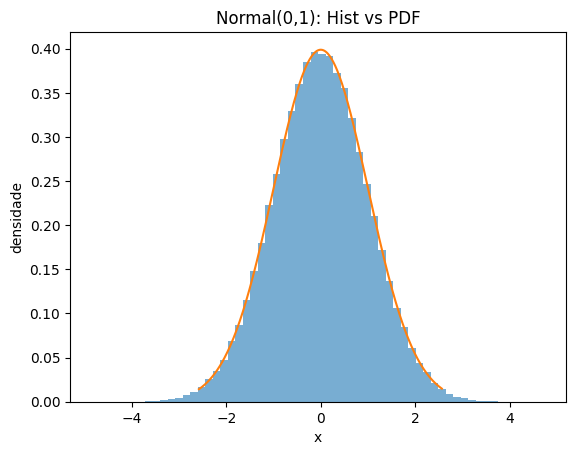

In [ ]:
# Contínuas — Normal (Polar) KS e Q–Q
def cdf_norm01(x): return 0.5*(1+math.erf(x/math.sqrt(2)))
def q_norm01(p):
    try:
        from scipy.stats import norm
        return norm.ppf(p)
    except Exception:
        a=[-3.969683028665376e+01,2.209460984245205e+02,-2.759285104469687e+02,1.383577518672690e+02,-3.066479806614716e+01,2.506628277459239e+00]
        b=[-5.447609879822406e+01,1.615858368580409e+02,-1.556989798598866e+02,6.680131188771972e+01,-1.328068155288572e+01]
        c=[-7.784894002430293e-03,-3.223964580411365e-01,-2.400758277161838e+00,-2.549732539343734e+00,4.374664141464968e+00,2.938163982698783e+00]
        d=[7.784695709041462e-03,3.224671290700398e-01,2.445134137142996e+00,3.754408661907416e+00]
        plow=0.02425; phigh=1-plow
        if p < plow:
            q = math.sqrt(-2*math.log(p)); num=(((((c[0]*q+c[1])*q+c[2])*q+c[3])*q+c[4])*q+c[5]); den=((((d[0]*q+d[1])*q+d[2])*q+d[3])*q+1); x = -num/den
        elif p > phigh:
            q = math.sqrt(-2*math.log(1-p)); num=(((((c[0]*q+c[1])*q+c[2])*q+c[3])*q+c[4])*q+c[5]); den=((((d[0]*q+d[1])*q+d[2])*q+d[3])*q+1); x = num/den
        else:
            q = p - 0.5; r = q*q
            num = (((((a[0]*r+a[1])*r+a[2])*r+a[3])*r+a[4])*r+a[5])*q
            den = (((((b[0]*r+b[1])*r+b[2])*r+b[3])*r+b[4])*r+1)
            x = num/den
        e = 0.5*(1+math.erf(x/math.sqrt(2))) - p; u = e * math.sqrt(2*math.pi) * math.exp(x*x/2)
        return x - u/(1 + x*u/2)

z_pl, tpl = time_draw(normal_polar, size=300_000, rng=rng)
stat_pl, p_pl = ks_continuous(z_pl, cdf_norm01)
print(f"Normal Polar: {tpl:.4f}s | KS stat={stat_pl:.4f} p={p_pl}")
qqplot(z_pl, q_norm01, title="Q–Q Normal(0,1) — Polar")
hist_with_pdf(z_pl, lambda x: (1/np.sqrt(2*np.pi))*np.exp(-0.5*x*x), title="Normal(0,1): Hist vs PDF")

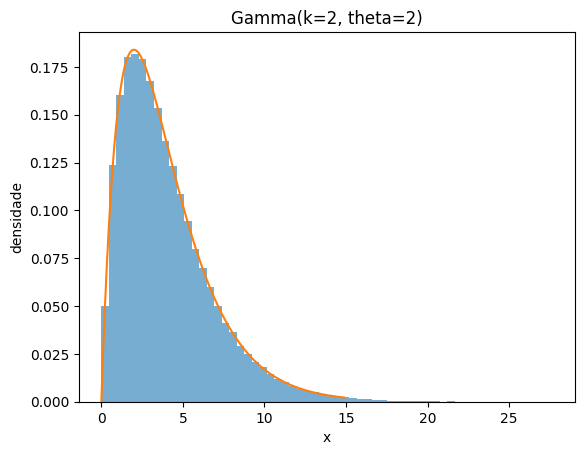

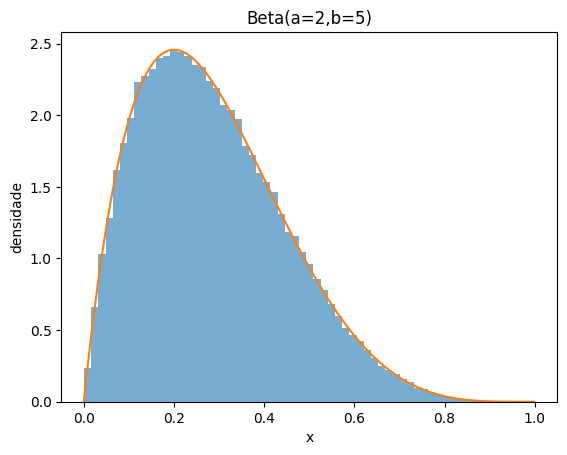

In [ ]:
# Contínuas — Gama e Beta
g = gamma(k=2.0, theta=2.0, size=150_000, rng=rng)
hist_with_pdf(g, lambda x: (x**(2-1))*np.exp(-x/2)/(math.gamma(2)*(2**2)), xmin=0.0, title="Gamma(k=2, theta=2)")
b = beta_ab(2.0, 5.0, size=150_000, rng=rng)
from math import gamma as Gm
B_ab = Gm(2.0)*Gm(5.0)/Gm(7.0)
hist_with_pdf(b, lambda x: (x**(2.0-1))*((1-x)**(5.0-1))/B_ab, xmin=0.0, xmax=1.0, title="Beta(a=2,b=5)")

## 6) Exercícios (com testes)
**Instruções:** complete as células `# A FAZER` e execute os **testes** logo abaixo de cada exercício.

### Ex 1. - Geométrica inversa

Implemente a geração de variáveis aleatórias Geométricas (contagem de tentativas, $X \ge 1$) usando o método da transformada inversa. A PMF é $P(X=k) = (1-p)^{k-1} p$ para $k=1, 2, \ldots$.A fórmula da inversa é: $X = \lceil \frac{\log(1-U)}{\log(1-p)} \rceil$.

In [ ]:
def geometric_inverse(p, size, rng=None):
    """Gera `size` amostras de Geométrica(p) (contando tentativas >= 1)"""
    rng = make_rng() if rng is None else rng
    u = rng.random(size)

    # --- IMPLEMENTE AQUI (aprox. 1-2 linhas) ---

    pass
    # -------------------------------------------

# ---- Testes e validação ----


Ex.1 OK — Zipf finita


### Ex.2 — Normal truncada em [a,b]
Implemente a normal truncada `trunc_normal_ab(a,b,size)` via **rejeição** simples e valide a média (tolerância 4×EP).

In [ ]:
def trunc_normal_ab(a, b, size, rng=None):
    rng = make_rng() if rng is None else rng
    # --- IMPLEMENTE AQUI (aprox. 4-5 linhas) ---

    pass
    # -------------------------------------------

# ---- Testes e validação ----


Ex.2 OK — Normal truncada [a,b]


### Ex.3 — Mistura Gaussiana 2‑componentes
Implemente a mistura de gaussianas `gauss_mixture(mu1,s1,mu2,s2,w,size)` e valide média/variância.

In [ ]:
def gauss_mixture(mu1, s1, mu2, s2, w, size, rng=None):
    rng = make_rng() if rng is None else rng
    # --- IMPLEMENTE AQUI (aprox. 4-5 linhas) ---

    pass
    # -------------------------------------------


# ---- Testes e validação ----


Ex.3 OK — Mistura Gaussiana


### Ex.4 — Utilização da Tabela de Renomeação
Utilize a tabela de renomeação (já implementada no caderno) para gerar variáveis com o seguinte padrão `[0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125, 0.00390625, 0.00390625]`

In [ ]:
def probabilidade_arbitraria(p, rng=None):
    rng = make_rng() if rng is None else rng
    # --- IMPLEMENTE AQUI (aprox. 4-5 linhas) ---

    pass
    # -------------------------------------------

# ---- Testes e validação ----
